In [578]:
import numpy as np
import random
import scipy.stats as ss
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd

# Basic threshold model

## Time to consensus

In [579]:
def extract_data(graph, opinion0_prob):
    G = nx.number_of_nodes(graph)
    nodes = list(graph.nodes())
    opinion0_count = int(opinion0_prob*G)
    opinions = [-1]*opinion0_count + [1]*(G - opinion0_count)
    random.shuffle(opinions)
    neighbors = [0]*G
    for i in range(G):
        neighbors[i] = list(graph.neighbors(nodes[i]))
    return opinions, neighbors

In [580]:
def sym_to_consensus(graph, opinion0_prob, q, q0, epsilon, max_steps = 10**6):
    last_values = np.empty(10000)
    data = extract_data(graph, opinion0_prob)
    opinions, neighbors = data
    len_opinions = len(opinions)
    step = 0
    while len(list(set(opinions))) == 2 and step < max_steps:
        chosen = np.random.randint(0, len_opinions)
        opinion = opinions[chosen]
        chosen_neighbors = random.sample(neighbors[chosen], k = q)
        chosen_opinions = [opinions[i] for i in chosen_neighbors]
        opposite_opinion = chosen_opinions.count(-1*opinion)
        if opposite_opinion >= q0 or (epsilon  > np.random.uniform() and opposite_opinion > 0):
            opinions[chosen] *= -1
        step += 1
        
    return step

In [581]:
def monte_carlo_sym_random(n, graph_prob, MC_steps, opinion0_prob, q, q0, epsilon, max_steps):
    mean_step = 0
    steps = 0
    counter = 0
    for i in range(MC_steps):
        g = nx.erdos_renyi_graph(n, graph_prob)
        while min(dict(g.degree()).values()) < q:
            print('Need more neighbors')
            g = nx.erdos_renyi_graph(n, graph_prob)
        steps = sym_to_consensus(g, opinion0_prob, q, q0, epsilon, max_steps)
        mean_step += steps
        if steps == max_steps:
            counter += 1
            if counter == 3:
                return 0
    return mean_step / MC_steps

In [582]:
def monte_carlo_sym_watts(n, watts_edges, watts_prob, MC_steps, opinion0_prob, q, q0, epsilon, max_steps):
    mean_step = 0
    steps = 0
    counter = 0
    for i in range(MC_steps):
        g = nx.watts_strogatz_graph(n, watts_edges, watts_prob)
        while min(dict(g.degree()).values()) < q:
            print('Need more neighbors')
            g = nx.watts_strogatz_graph(n, watts_edges, watts_prob)
        steps += sym_to_consensus(g, opinion0_prob, q, q0, epsilon, max_steps)
        mean_step += steps
        if steps == max_steps:
            counter += 1
            if counter == 3:
                return 0
    return mean_step / MC_steps

In [583]:
def monte_carlo_sym_barabasi(n, barabasi_edges, MC_steps, opinion0_prob, q, q0, epsilon, max_steps):
    mean_step = 0
    steps = 0
    counter = 0
    for i in range(MC_steps):
        g = nx.barabasi_albert_graph(n, barabasi_edges)
        while min(dict(g.degree()).values()) < q:
            print('Need more neighbors')
            barabasi_edges += 1
            g = nx.barabasi_albert_graph(N, barabasi_edges)
        steps = sym_to_consensus(g, opinion0_prob, q, q0, epsilon, max_steps)
        mean_step += steps
        if steps == max_steps:
            counter += 1
            if counter == 3:
                print((0, i))
                return 0
    return mean_step / MC_steps

In [584]:
def consensus_time_random(ns, graph_prob, epsilon, MC_steps, opinion0_prob, q, q0, max_steps = 10**6):
    mean_times = np.empty(len(ns))
    for n in range(len(ns)):
        print(ns[n])
        mean_times[n] = monte_carlo_sym_random(ns[n], graph_prob, MC_steps, opinion0_prob, q, q0, epsilon, max_steps)
    return mean_times

In [585]:
def consensus_time_barabasi(ns, barabasi_edges, epsilon, MC_steps, opinion0_prob, q, q0, max_steps = 10**6):
    mean_times = np.empty(len(ns))
    for n in range(len(ns)):
        print(ns[n])
        mean_times[n] = monte_carlo_sym_barabasi(ns[n], barabasi_edges, MC_steps, opinion0_prob, q, q0, epsilon, max_steps)
    return mean_times

In [586]:
def consensus_time_watts(ns, watts_edges, watts_prob, epsilon, MC_steps, opinion0_prob, q, q0, max_steps = 10**6):
    mean_times = np.empty(len(ns))
    for n in range(len(ns)):
        print(ns[n])
        mean_times[n] = monte_carlo_sym_watts(ns[n], watts_edges, watts_prob, MC_steps, opinion0_prob, q, q0, epsilon, max_steps)
    return mean_times

### Barabasi

In [393]:
ns = [100, 250, 500, 1000, 1500, 2000, 2500, 3000, 4000, 5000]
epsilons = np.arange(0.1, 0.5, 0.1)
q = 6
q0 = 4
MC_steps = 100
opinion0_prob = 0.5
barabasi_edges = 8

In [394]:
%%time
l = []
for e in epsilons:
    print(e)
    l.append(consensus_time_barabasi(ns, barabasi_edges, e, MC_steps, opinion0_prob, q, q0, max_steps = 10**6))

0.1
100
Need more neighbors


UnboundLocalError: local variable 'edges' referenced before assignment

In [ ]:
df = pd.DataFrame(l, columns = ns)
df.to_csv('Barabasi.csv')
df = pd.DataFrame(big_steps_barabasi, columns = ns)
df.to_csv('Barabasi_big.csv')

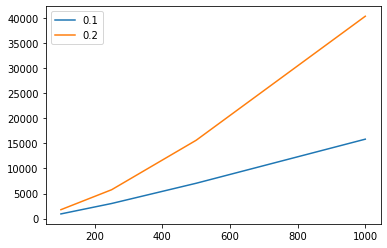

In [203]:
for e in l:
    plt.plot(ns, e)
plt.legend(epsilons)

### Watts

In [65]:
ns = [100, 250, 500, 1000, 1500, 2000, 2500, 3000, 4000, 5000]
epsilons = np.arange(0.1, 0.45, 0.05)
q = 6
q0 = 4
MC_steps = 100
opinion0_prob = 0.5 
watts_edges, watts_prob = 12, 0.5

In [ ]:
%%time
l = []
for e in epsilons:
    print(e)
    l.append(consensus_time_watts(ns, watts_edges, watts_prob, e, MC_steps, opinion0_prob, q, q0, max_steps = 10**6))

0.1
100
250
500
1000
1500
2000
2500
3000
4000
5000
0.15000000000000002
100
250
500
1000
1500
2000
2500
3000
4000
5000
0.20000000000000004
100
250
500
1000
1500
2000
2500
3000
4000
5000
0.25000000000000006
100
250
500
1000
1500
2000
2500
3000
4000
5000
0.30000000000000004
100
250
500
1000
1500
2000
2500
3000
4000


In [ ]:
df = pd.DataFrame(l, columns = ns)
df.to_csv('Watts.csv')
df = pd.DataFrame(big_steps_watts, columns = ns)
df.to_csv('Watts_big.csv')

In [ ]:
for e in l:
    plt.plot(ns, e)
plt.legend(epsilons)

### Random

In [ ]:
ns = [100, 250, 500, 1000, 1500, 2000, 2500, 3000, 4000, 5000]
epsilons = np.arange(0.1, 0.45, 0.05)
q = 6
q0 = 4
MC_steps = 100
opinion0_prob = 0.5 
graph_prob = 1

In [ ]:
%%time
l = []
for e in epsilons:
    print(e)
    l.append(consensus_time_random(ns, graph_prob, e, MC_steps, opinion0_prob, q, q0, max_steps = 10**6))

In [ ]:
df = pd.DataFrame(l, columns = ns)
df.to_csv('Random.csv')
df = pd.DataFrame(big_steps_random, columns = ns)
df.to_csv('random_big.csv')

In [ ]:
for e in l[:-1]:
    plt.plot(ns, e)
plt.plot(ns[:3], l[-1][:3])
plt.legend(epsilons)

In [ ]:
def monte_carlo_sym_random(n, graph_prob, MC_steps, graph, opinion0_prob, q, q0, epsilon, max_steps):
    mean_step = 0
    for i in range(MC_steps):
        g = nx.erdos_renyi_graph(n, graph_prob)
        while min(dict(g.degree()).values()) < q:
            print('Need more neighbors')
            g = nx.erdos_renyi_graph(ns[n], graph_prob)
        mean_step += sym_to_consensus(g, opinion0_prob, q, q0, epsilon, big_steps_random2, max_steps)
    return mean_step/MC_steps

In [ ]:
ns = [100, 250, 500, 1000, 1500, 2000, 2500, 3000, 4000, 5000]
epsilons = np.arange(0.1, 0.45, 0.05)
q = 6
q0 = 4
MC_steps = 100
opinion0_prob = 0.5 
graph_prob = 0.6

In [ ]:
%%time
l = []
for e in epsilons:
    print(e)
    l.append(consensus_time_random(ns, graph_prob, e, MC_steps, opinion0_prob, q, q0, max_steps = 10**6))

In [ ]:
df = pd.DataFrame(l, columns = ns)
df.to_csv('Random2.csv')
df = pd.DataFrame(big_steps_random2, columns = ns)
df.to_csv('random_big2.csv')

## Magnetization

In [587]:
def sym_magnetization(graph, opinion0_prob, q, q0, epsilon, max_steps = 10**6):
    last_values = np.empty(10000)
    data = extract_data(graph, opinion0_prob)
    opinions, neighbors = data
    len_opinions = len(opinions)
    step = 0
    magnetization = np.empty(max_steps)
    while len(list(set(opinions))) == 2 and step < max_steps:
        chosen = np.random.randint(0, len_opinions)
        opinion = opinions[chosen]
        chosen_neighbors = random.sample(neighbors[chosen], k = q)
        chosen_opinions = [opinions[i] for i in chosen_neighbors]
        opposite_opinion = chosen_opinions.count(-1*opinion)
        if opposite_opinion >= q0 or (epsilon  > np.random.uniform() and opposite_opinion > 0):
            opinions[chosen] *= -1
        magnetization[step] = sum(opinions)/len_opinions
        step += 1
    magnetization[step:] = magnetization[step - 1]
    return magnetization

In [588]:
def avg_magnetization_random(N, graph_prob, MCsteps, opinion0_prob, q, q0, epsilon, max_steps = 10**6):
    results = np.empty((MCsteps, max_steps))
    for i in range(MCsteps):
        g = nx.erdos_renyi_graph(N, graph_prob)
        while min(dict(g.degree()).values()) < q:
            print('Need more neighbors')
            g = nx.erdos_renyi_graph(N, graph_prob)
        results[i] = abs(sym_magnetization(g, opinion0_prob, q, q0, epsilon, max_steps))
    return np.mean(results, axis = 0)

In [589]:
def avg_magnetization_watts(N, watts_edges, watts_prob, MCsteps, opinion0_prob, q, q0, epsilon, max_steps = 10**6):
    results = np.empty((MCsteps, max_steps))
    for i in range(MCsteps):
        g = nx.watts_strogatz_graph(N, watts_edges, watts_prob)
        while min(dict(g.degree()).values()) < q:
            print('Need more neighbors')
            watts_edges += 1
            g = nx.watts_strogatz_graph(N, watts_edges, watts_prob)
        results[i] = abs(sym_magnetization(g, opinion0_prob, q, q0, epsilon, max_steps))
    return np.mean(results, axis = 0)

In [590]:
def avg_magnetization_barabasi(N, barabasi_edges, MCsteps, opinion0_prob, q, q0, epsilon, max_steps = 10**6):
    results = np.empty((MCsteps, max_steps))
    for i in range(MCsteps):
        g = nx.barabasi_albert_graph(N, barabasi_edges)
        while min(dict(g.degree()).values()) < q:
            print('Need more neighbors')
            barabasi_edges += 1
            g = nx.barabasi_albert_graph(N, barabasi_edges)
        results[i] = abs(sym_magnetization(g, opinion0_prob, q, q0, epsilon, max_steps))
    return np.mean(results, axis = 0)

In [591]:
def avg_magnetization_random_last(N, graph_prob, MCsteps, opinion0_prob, q, q0, epsilon, max_steps = 10**6):
    results = np.empty(MCsteps)
    for i in range(MCsteps):
        g = nx.erdos_renyi_graph(N, graph_prob)
        while min(dict(g.degree()).values()) < q:
            print('Need more neighbors')
            g = nx.erdos_renyi_graph(N, graph_prob)
        results[i] = abs(sym_magnetization(g, opinion0_prob, q, q0, epsilon, max_steps)[-1])
    return np.mean(results)

In [592]:
def avg_magnetization_watts_last(N, watts_edges, watts_prob, MCsteps, opinion0_prob, q, q0, epsilon, max_steps = 10**6):
    results = np.empty(MCsteps)
    for i in range(MCsteps):
        g = nx.watts_strogatz_graph(N, watts_edges, watts_prob)
        while min(dict(g.degree()).values()) < q:
            print('Need more neighbors')
            watts_edges += 1
            g = nx.watts_strogatz_graph(N, watts_edges, watts_prob)
        results[i] = abs(sym_magnetization(g, opinion0_prob, q, q0, epsilon, max_steps)[-1])
    return np.mean(results)

In [593]:
def avg_magnetization_barabasi_last(N, barabasi_edges, MCsteps, opinion0_prob, q, q0, epsilon, max_steps = 10**6):
    results = np.empty(MCsteps)
    for i in range(MCsteps):
        g = nx.barabasi_albert_graph(N, barabasi_edges)
        while min(dict(g.degree()).values()) < q:
            print('Need more neighbors')
            barabasi_edges += 1
            g = nx.barabasi_albert_graph(N, barabasi_edges)
        results[i] = abs(sym_magnetization(g, opinion0_prob, q, q0, epsilon, max_steps)[-1])
    return np.mean(results)

# Our modification

## Time to consensus

In [594]:
def extract_data_common(graph, opinion0_prob):
    G = nx.number_of_nodes(graph)
    nodes = list(graph.nodes())
    opinion0_count = int(opinion0_prob*G)
    opinions = [-1]*opinion0_count + [1]*(G - opinion0_count)
    random.shuffle(opinions)
    neighbors = [0]*G
    common = np.zeros((G, G))
    for i in range(G):
        neighbors[i] = list(graph.neighbors(nodes[i]))
    for i in range(G):
        for j in range(G):
            common[i][j] = len(set(neighbors[i]) & set(neighbors[j]))
    return opinions, neighbors, common

In [595]:
def sym_to_consensus_common(graph, opinion0_prob, q, q0, epsilon, max_steps = 10**6):
    last_values = np.empty(10000)
    opinions, neighbors, common = extract_data_common(graph, opinion0_prob)
    len_opinions = len(opinions)
    step = 0
    while len(list(set(opinions))) == 2 and step < max_steps:
        chosen = np.random.randint(0, len_opinions)
        opinion = opinions[chosen]
        chosen_neighbors = random.sample(neighbors[chosen], k = q)
        chosen_opinions = np.array([opinions[i] for i in chosen_neighbors])
        chosen_common = [common[chosen, i] for i in chosen_neighbors]
        opposite_inds = np.where(chosen_opinions == -1*opinion)[0]
        opposite_opinion = np.sum([chosen_common[i] for i in opposite_inds]) / np.sum(chosen_common) \
            if np.sum(chosen_common) > 0 else 0
        
        if opposite_opinion > q0 or (epsilon > np.random.uniform() and opposite_opinion > 0):
            opinions[chosen] *= -1
        step += 1
        
    return step

In [596]:
def monte_carlo_sym_random_common(n, graph_prob, MC_steps, opinion0_prob, q, q0, epsilon, max_steps):
    mean_step = 0
    steps = 0
    counter = 0
    for i in range(MC_steps):
        g = nx.erdos_renyi_graph(n, graph_prob)
        while min(dict(g.degree()).values()) < q:
            print('Need more neighbors')
            g = nx.erdos_renyi_graph(n, graph_prob)
        steps = sym_to_consensus_common(g, opinion0_prob, q, q0, epsilon, max_steps)
        mean_step += steps
        if steps == max_steps:
            counter += 1
            if counter == 3:
                return 0
    return mean_step / MC_steps

In [597]:
def monte_carlo_sym_barabasi_common(n, barabasi_edges, MC_steps, opinion0_prob, q, q0, epsilon, max_steps):
    mean_step = 0
    steps = 0
    counter = 0
    for i in range(MC_steps):
        g = nx.barabasi_albert_graph(n, barabasi_edges)
        while min(dict(g.degree()).values()) < q:
            print('Need more neighbors')
            barabasi_edges += 1
            g = nx.barabasi_albert_graph(N, barabasi_edges)
        steps = sym_to_consensus_common(g, opinion0_prob, q, q0, epsilon, max_steps)
        mean_step += steps
        if steps == max_steps:
            counter += 1
            if counter == 3:
                print((0, i))
                return 0
    return mean_step / MC_steps

In [598]:
def monte_carlo_sym_watts_common(n, watts_edges, watts_prob, MC_steps, opinion0_prob, q, q0, epsilon, max_steps):
    mean_step = 0
    steps = 0
    counter = 0
    for i in range(MC_steps):
        g = nx.watts_strogatz_graph(n, watts_edges, watts_prob)
        while min(dict(g.degree()).values()) < q:
            print('Need more neighbors')
            watts_edges += 1
            g = nx.watts_strogatz_graph(n, watts_edges, watts_prob)
        steps += sym_to_consensus_common(g, opinion0_prob, q, q0, epsilon, max_steps)
        mean_step += steps
        if steps == max_steps:
            counter += 1
            if counter == 3:
                return 0
    return mean_step / MC_steps

In [599]:
def consensus_time_random_common(ns, graph_prob, epsilon, MC_steps, opinion0_prob, q, q0, max_steps = 10**6):
    mean_times = np.empty(len(ns))
    for n in range(len(ns)):
        print(ns[n])
        mean_times[n] = monte_carlo_sym_random_common(ns[n], graph_prob, MC_steps, opinion0_prob, q, q0, epsilon, max_steps)
    return mean_times

In [600]:
def consensus_time_barabasi_common(ns, barabasi_edges, epsilon, MC_steps, opinion0_prob, q, q0, max_steps = 10**6):
    mean_times = np.empty(len(ns))
    for n in range(len(ns)):
        print(ns[n])
        mean_times[n] = monte_carlo_sym_barabasi_common(ns[n], barabasi_edges, MC_steps, opinion0_prob, q, q0, epsilon, max_steps)
    return mean_times

In [601]:
def consensus_time_watts_common(ns, watts_edges, watts_prob, epsilon, MC_steps, opinion0_prob, q, q0, max_steps = 10**6):
    mean_times = np.empty(len(ns))
    for n in range(len(ns)):
        print(ns[n])
        mean_times[n] = monte_carlo_sym_watts_common(ns[n], watts_edges, watts_prob, MC_steps, opinion0_prob, q, q0, epsilon, max_steps)
    return mean_times

## Magnetization

In [602]:
def sym_magnetization_common(graph, opinion0_prob, q, q0, epsilon, max_steps = 10**6):
    last_values = np.empty(10000)
    opinions, neighbors, common = extract_data_common(graph, opinion0_prob)
    len_opinions = len(opinions)
    step = 0
    magnetization = np.empty(max_steps)
    while len(list(set(opinions))) == 2 and step < max_steps:
        chosen = np.random.randint(0, len_opinions)
        opinion = opinions[chosen]
        chosen_neighbors = random.sample(neighbors[chosen], k = q)
        chosen_opinions = np.array([opinions[i] for i in chosen_neighbors])
        chosen_common = [common[chosen, i] for i in chosen_neighbors]
        opposite_inds = np.where(chosen_opinions == -1*opinion)[0]
        sum_chosen = np.sum(chosen_common)
        opposite_opinion = np.sum([chosen_common[i] for i in opposite_inds]) / sum_chosen \
            if sum_chosen > 0 else 0
        
        if opposite_opinion > q0 or (epsilon > np.random.uniform() and opposite_opinion > 0):
            opinions[chosen] *= -1
        magnetization[step] = sum(opinions)/len_opinions
        step += 1
    magnetization[step:] = magnetization[step - 1]
    return magnetization 

In [603]:
def avg_magnetization_common_random(N, graph_prob, MCsteps, opinion0_prob, q, q0, epsilon, max_steps = 10**6):
    results = np.empty((MCsteps, max_steps))
    for i in range(MCsteps):
        g = nx.erdos_renyi_graph(N, graph_prob)
        while min(dict(g.degree()).values()) < q:
            print('Need more neighbors')
            g = nx.erdos_renyi_graph(N, graph_prob)
        results[i] = abs(sym_magnetization_common(g, opinion0_prob, q, q0, epsilon, max_steps))
    return np.mean(results, axis = 0)

In [604]:
def avg_magnetization_common_watts(N, watts_edges, watts_prob, MCsteps, opinion0_prob, q, q0, epsilon, max_steps = 10**6):
    results = np.empty((MCsteps, max_steps))
    for i in range(MCsteps):
        g = nx.watts_strogatz_graph(N, watts_edges, watts_prob)
        while min(dict(g.degree()).values()) < q:
            print('Need more neighbors')
            watts_edges += 1
            g = nx.watts_strogatz_graph(N, watts_edges, watts_prob)
        results[i] = abs(sym_magnetization_common(g, opinion0_prob, q, q0, epsilon, max_steps))
    return np.mean(results, axis = 0)

In [605]:
def avg_magnetization_common_barabasi(N, barabasi_edges, MCsteps, opinion0_prob, q, q0, epsilon, max_steps = 10**6):
    results = np.empty((MCsteps, max_steps))
    for i in range(MCsteps):
        if i % 10 == 0:
            print(i)
        g = nx.barabasi_albert_graph(N, barabasi_edges)
        while min(dict(g.degree()).values()) < q:
            print('Need more neighbors')
            barabasi_edges += 1
            g = nx.barabasi_albert_graph(N, barabasi_edges)
        results[i] = abs(sym_magnetization_common(g, opinion0_prob, q, q0, epsilon, max_steps))
    return np.mean(results, axis = 0)

In [606]:
def avg_magnetization_common_random_last(N, graph_prob, MCsteps, opinion0_prob, q, q0, epsilon, max_steps = 10**6):
    results = np.empty(MCsteps)
    for i in range(MCsteps):
        g = nx.erdos_renyi_graph(N, graph_prob)
        while min(dict(g.degree()).values()) < q:
            print('Need more neighbors')
            g = nx.erdos_renyi_graph(N, graph_prob)
        results[i] = abs(sym_magnetization_common(g, opinion0_prob, q, q0, epsilon, max_steps)[-1])
    return np.mean(results)

In [607]:
def avg_magnetization_common_watts_last(N, watts_edges, watts_prob, MCsteps, opinion0_prob, q, q0, epsilon, max_steps = 10**6):
    results = np.empty(MCsteps)
    for i in range(MCsteps):
        g = nx.watts_strogatz_graph(N, watts_edges, watts_prob)
        while min(dict(g.degree()).values()) < q:
            print('Need more neighbors')
            watts_edges += 1
            g = nx.watts_strogatz_graph(N, watts_edges, watts_prob)
        results[i] = abs(sym_magnetization_common(g, opinion0_prob, q, q0, epsilon, max_steps)[-1])
    return np.mean(results)

In [608]:
def avg_magnetization_common_barabasi_last(N, barabasi_edges, MCsteps, opinion0_prob, q, q0, epsilon, max_steps = 10**6):
    results = np.empty(MCsteps)
    for i in range(MCsteps):
        g = nx.barabasi_albert_graph(N, barabasi_edges)
        while min(dict(g.degree()).values()) < q:
            print('Need more neighbors')
            barabasi_edges += 1
            g = nx.barabasi_albert_graph(N, barabasi_edges)
        results[i] = abs(sym_magnetization_common(g, opinion0_prob, q, q0, epsilon, max_steps)[-1])
    return np.mean(results)

In [611]:
mag_barabasi = avg_magnetization_common_barabasi(N = 100, barabasi_edges = 6, MCsteps = 100, opinion0_prob = 0.5, q = 6, q0 = 1/2, epsilon = 0.1, max_steps = 10**6)

0
Need more neighbors
Need more neighbors
Need more neighbors
Need more neighbors
Need more neighbors
Need more neighbors
Need more neighbors
Need more neighbors
10
Need more neighbors
Need more neighbors
20
Need more neighbors
Need more neighbors
Need more neighbors
30
Need more neighbors
40
Need more neighbors
Need more neighbors
Need more neighbors
50
60
Need more neighbors
70
Need more neighbors
Need more neighbors
Need more neighbors
80
90


In [612]:
mag_barabasi1 = avg_magnetization_barabasi(N = 100, barabasi_edges = 6, MCsteps = 100, opinion0_prob = 0.5, q = 6, q0 = 3, epsilon = 0.1, max_steps = 10**6)

Need more neighbors
Need more neighbors
Need more neighbors
Need more neighbors
Need more neighbors
Need more neighbors
Need more neighbors
Need more neighbors
Need more neighbors
Need more neighbors
Need more neighbors
Need more neighbors
Need more neighbors
Need more neighbors
Need more neighbors
Need more neighbors


In [613]:
mag_watts = avg_magnetization_watts(N = 100, watts_edges = 11, watts_prob = 0.5, MCsteps = 100, opinion0_prob = 0.5, q = 6, q0 = 3, epsilon = 0.1, max_steps = 10**6)

Need more neighbors


In [ ]:
mag_watts1 = avg_magnetization_common_watts(N = 100, watts_edges = 11, watts_prob = 0.5, MCsteps = 100, opinion0_prob = 0.5, q = 6, q0 = 1/2, epsilon = 0.1, max_steps = 10**6)

Need more neighbors


In [ ]:
mag_random = avg_magnetization_common_random(N = 100, graph_prob = 0.5, MCsteps = 100, opinion0_prob = 0.5, q = 6, q0 = 1/2, epsilon = 0.1, max_steps = 10**6)

In [ ]:
mag_random1 = avg_magnetization_random(N = 100, graph_prob = 0.5, MCsteps = 100, opinion0_prob = 0.5, q = 6, q0 = 3, epsilon = 0.1, max_steps = 10**6)

In [ ]:
plt.plot(mag_barabasi[1:1000])
plt.plot(mag_barabasi1[1:1000])

In [ ]:
plt.plot(mag_watts[1:1000])
plt.plot(mag_watts1[1:1000])

In [ ]:
plt.plot(mag_random[1:1000])
plt.plot(mag_random1[1:1000])

In [72]:
ns = [100, 250, 500, 1000]
epsilons = np.arange(0.1, 0.3, 0.1)
q = 6
q0 = 2/3
MC_steps = 100
opinion0_prob = 0.5
barabasi_edges = 8

In [73]:
%%time
l = []
for e in epsilons:
    print(e)
    l.append(consensus_time_barabasi_common(ns, barabasi_edges, e, MC_steps, opinion0_prob, q, q0, max_steps = 10**6))

0.1
100
(0, 16)
250
(0, 5)
500


KeyboardInterrupt: 

In [78]:
barabasz1 = avg_magnetization_barabasi(100, 8, 100, 0.5, 6, 4, 0.1, max_steps = 10**6)

In [ ]:
barabasz2 = avg_magnetization_barabasi(100, 8, 100, 0.5, 6, 4, 0.1, max_steps = 10**6)